In [1]:
!mkdir -p data models

In [1]:
%%writefile data/mnist.py
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader


def get_mnist_dataloaders(batch_size=64, data_dir='./data'):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # scale images to [-1, 1]
    ])

    train_dataset = MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_dataset = MNIST(root=data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Writing data/mnist.py


In [2]:
%%writefile models/unet.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.norm2 = nn.GroupNorm(32, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        t_emb = self.time_mlp(t)[:, :, None, None]
        h = h + t_emb
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        k = self.k(x_norm).reshape(b, c, -1)
        v = self.v(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        attn = torch.bmm(q, k) * (c ** -0.5)
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(b, c, h, w)
        return x + self.proj_out(out)

class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(channels, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

def center_crop(x, target_shape):
    _, _, h, w = x.shape
    th, tw = target_shape
    start_h = (h - th) // 2
    start_w = (w - tw) // 2
    return x[:, :, start_h:start_h+th, start_w:start_w+tw]

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)
        self.downsample = Downsample(out_channels)

    def forward(self, x, t):
        skip_connections = []
        for block in self.res_blocks:
            x = block(x, t)
            skip_connections.append(x)
        if self.use_attn:
            x = self.attn(x)
        x_down = self.downsample(x)
        return x_down, skip_connections

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels + out_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)

    def forward(self, x, skip_connections, t):
        x = self.upsample(x)
        skip = skip_connections.pop()  # one skip connection per block
        if x.shape[2:] != skip.shape[2:]:
            x = center_crop(x, skip.shape[2:])
        x = torch.cat([x, skip], dim=1)
        for block in self.res_blocks:
            x = block(x, t)
        if self.use_attn:
            x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64,
                 channel_mults=(1, 2, 4), num_res_blocks=2, time_emb_dim=256,
                 attn_resolutions=None):
        super().__init__()
        if attn_resolutions is None:
            attn_resolutions = []

        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.down_blocks = nn.ModuleList()
        in_ch = base_channels
        for i, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            use_attn = (i in attn_resolutions)
            self.down_blocks.append(DownBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch

        self.mid_block1 = ResBlock(in_ch, in_ch, time_emb_dim)
        self.mid_attn = AttentionBlock(in_ch)
        self.mid_block2 = ResBlock(in_ch, in_ch, time_emb_dim)

        self.up_blocks = nn.ModuleList()
        for i, mult in enumerate(reversed(channel_mults)):
            out_ch = base_channels * mult
            use_attn = ((len(channel_mults) - 1 - i) in attn_resolutions)
            self.up_blocks.append(UpBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch

        self.final_norm = nn.GroupNorm(32, in_ch)
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(in_ch, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        t = t.to(x.device)
        t_emb = self.time_embedding(t)
        x = self.initial_conv(x)
        skip_connections_all = []
        for block in self.down_blocks:
            x, skip_connections = block(x, t_emb)
            skip_connections_all.append(skip_connections)
        x = self.mid_block1(x, t_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_emb)
        for block in self.up_blocks:
            skip_connections = skip_connections_all.pop()
            x = block(x, skip_connections, t_emb)
        x = self.final_norm(x)
        x = self.final_act(x)
        return self.final_conv(x)

Writing models/unet.py


In [3]:
%%writefile models/diffusion.py
import torch
import torch.nn.functional as F
import pytorch_lightning as pl


class DiffusionModel(pl.LightningModule):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02, lr=1e-3):
        super().__init__()
        self.model = model
        self.T = T
        self.lr = lr

        beta = torch.linspace(beta_start, beta_end, T)
        alpha = 1.0 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        self.register_buffer("beta", beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_bar", alpha_bar)
        self.register_buffer("sqrt_alpha_bar", torch.sqrt(alpha_bar))
        self.register_buffer("sqrt_one_minus_alpha_bar", torch.sqrt(1 - alpha_bar))

    def forward(self, x, t):
        return self.model(x, t)

    def training_step(self, batch, batch_idx):
        x, _ = batch  # (B,1,28,28) images expected in [-1,1]
        B = x.size(0)
        device = x.device

        t = torch.randint(0, self.T, (B,), device=device)
        sqrt_alpha_bar_t = self.sqrt_alpha_bar[t].view(B, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[t].view(B, 1, 1, 1)
        noise = torch.randn_like(x)
        x_t = sqrt_alpha_bar_t * x + sqrt_one_minus_alpha_bar_t * noise

        pred_noise = self(x_t, t)
        loss = F.mse_loss(pred_noise, noise)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample(self, n_samples, ddim_steps=None, eta=0.0):
        device = self.device
        if ddim_steps is None:
            ddim_steps = self.T
            step_size = 1
        else:
            step_size = self.T // ddim_steps

        x = torch.randn(n_samples, 1, 28, 28, device=device)
        for i in range(self.T - 1, -1, -step_size):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            eps = self(x, t)
            sqrt_alpha_bar_t = self.sqrt_alpha_bar[i].view(1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[i].view(1, 1, 1, 1)
            x0_pred = (x - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alpha_bar_t
            t_prev = max(i - step_size, 0)
            sqrt_alpha_bar_t_prev = self.sqrt_alpha_bar[t_prev].view(1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t_prev = self.sqrt_one_minus_alpha_bar[t_prev].view(1, 1, 1, 1)
            x = sqrt_alpha_bar_t_prev * x0_pred + sqrt_one_minus_alpha_bar_t_prev * eps
        return x

Writing models/diffusion.py


In [4]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from models.unet import UNet
from models.diffusion import DiffusionModel
from data.mnist import get_mnist_dataloaders

In [6]:
%%capture
train_loader, test_loader = get_mnist_dataloaders(batch_size=256)

In [7]:
unet_model = UNet(in_channels=1, out_channels=1)
diffusion_model = DiffusionModel(model=unet_model, T=1000, lr=1e-3)

In [8]:
trainer = pl.Trainer(
    max_epochs=40,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(diffusion_model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matm

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


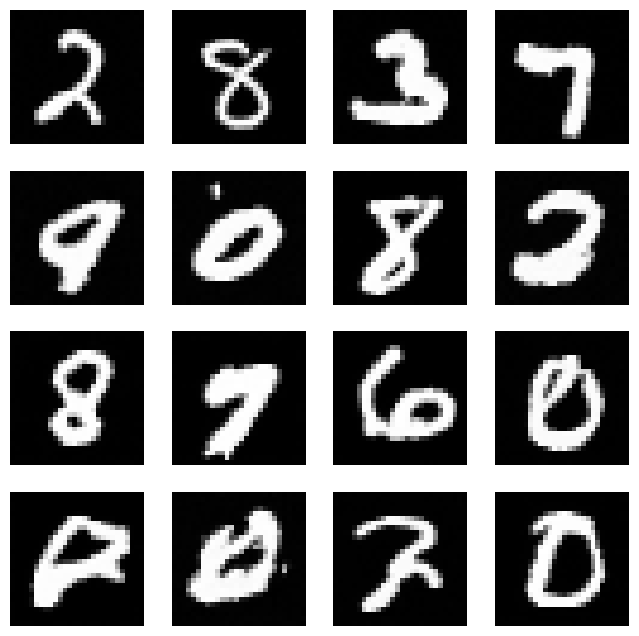

In [10]:
samples = diffusion_model.sample(n_samples=16, ddim_steps=100)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.show()